<a href="https://colab.research.google.com/github/Riishhab/ComputerScienceFYP/blob/main/FYP_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Rishab Agarwal <br>
Student ID: w1927516 <br>
Course: BSc Computer Science <br>
Computer Science Final Year Project <br>
Supervisor:

Portfolio Optimisation <br><br>
[1] <br>
Importing all the neccessary libraries and fetching the financial dataset from Yahoo finance api. <br>
Calculating means returns and covariance matrix of the data, as it is required for financial optimisation.

In [1]:
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid

from scipy.optimize import minimize

# Function to get historical financial data for given asset symbols and defined time period
def fetch_data(symbols, start_date, end_date):
    data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
    return data

# Asset symbols
equity_symbols = ['^GSPC', '^DJI', '^IXIC']  # S&P 500, Dow Jones, Nasdaq
fixed_income_symbols = ['AGG', 'BND']  # iShares Core U.S. Aggregate Bond ETF, Vanguard Total Bond Market ETF
commodities_symbols = ['^SPGSCI', 'GLD']  # S&P GSCI Total Return Index, SPDR Gold Trust ETF
reits_symbols = ['VNQ', 'IYR']  # Vanguard Real Estate ETF, iShares U.S. Real Estate ETF

# Time period - last 5 years data
start_date = datetime.datetime(2019, 1, 25)
end_date = datetime.datetime(2024, 1, 19)

# Running the fetch function
equity_data = fetch_data(equity_symbols, start_date, end_date)
fixed_income_data = fetch_data(fixed_income_symbols, start_date, end_date)
commodities_data = fetch_data(commodities_symbols, start_date, end_date)
reits_data = fetch_data(reits_symbols, start_date, end_date)

# To display the first few rows of each dataset
print('\n')
print("Equity Data:")
print(equity_data.head())

print("\nFixed Income Data:")
print(fixed_income_data.head())

print("\nCommodities Data:")
print(commodities_data.head())

print("\nREITs Data:")
print(reits_data.head())

# Daily returns
equity_returns = equity_data.pct_change().dropna()
fixed_income_returns = fixed_income_data.pct_change().dropna()
commodities_returns = commodities_data.pct_change().dropna()
reits_returns = reits_data.pct_change().dropna()

# Calculating mean returns
equity_mean_returns = equity_returns.mean()
fixed_income_mean_returns = fixed_income_returns.mean()
commodities_mean_returns = commodities_returns.mean()
reits_mean_returns = reits_returns.mean()

# Printing mean returns
mean_returns_table = pd.concat([equity_mean_returns, fixed_income_mean_returns, commodities_mean_returns, reits_mean_returns], axis=1)
print("\nMean Returns:")
print(mean_returns_table)

# Calculating covariance matrix
cov_matrix = pd.concat([equity_returns, fixed_income_returns, commodities_returns, reits_returns], axis=1).cov()
print("\nCovariance Matrix:")
print(cov_matrix)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed




Equity Data:
Ticker              ^DJI        ^GSPC        ^IXIC
Date                                              
2019-01-25  24737.199219  2664.760010  7164.859863
2019-01-28  24528.220703  2643.850098  7085.680176
2019-01-29  24579.960938  2640.000000  7028.290039
2019-01-30  25014.859375  2681.050049  7183.080078
2019-01-31  24999.669922  2704.100098  7281.740234

Fixed Income Data:
Ticker            AGG        BND
Date                            
2019-01-25  94.487968  69.850349
2019-01-28  94.434845  69.876732
2019-01-29  94.682831  70.017380
2019-01-30  94.895416  70.087715
2019-01-31  95.178833  70.413017

Commodities Data:
Ticker             GLD     ^SPGSCI
Date                              
2019-01-25  122.860001  409.690002
2019-01-28  123.290001  401.279999
2019-01-29  123.980003  407.100006
2019-01-30  124.690002  410.380005
2019-01-31  124.750000  407.890015

REITs Data:
Ticker            IYR        VNQ
Date                            
2019-01-25  70.011528  66.879433
2

[2] <br>
Running a basic optimisation on the dataset to produce the optimal weights.

In [2]:
# Creating the weight variables for each asset
num_assets = len(mean_returns_table)
weights = cp.Variable((num_assets, 1))

# Converting mean_returns_table dimensions from 9x9 to 9x1 by droping NaN cells.
mean_returns_table_long = mean_returns_table.stack().reset_index(level=1, drop=True).to_frame(name='Mean Returns')
print("\nMean Returns Table Long:")
print(mean_returns_table_long)

# Setting up the expected return and risk (standard deviation) of the portfolio
# Matrix multiplication between the mean returns and the weights.
expected_return = mean_returns_table_long.values.T @ weights
risk = cp.quad_form(weights, cov_matrix.values)

# Defining the optimization problem
objective = cp.Maximize(expected_return)
constraints = [cp.sum(weights) == 1, weights >= 0]
problem = cp.Problem(objective, constraints)

# Running the solver
problem.solve()

# Displaying the optimized results
print("\nOptimal Weights:")
print(weights.value)
print("\nExpected Return:", expected_return.value)
print("Risk:", np.sqrt(risk.value))


Mean Returns Table Long:
         Mean Returns
Ticker               
^DJI         0.000418
^GSPC        0.000557
^IXIC        0.000718
AGG          0.000038
BND          0.000041
GLD          0.000381
^SPGSCI      0.000350
IYR          0.000299
VNQ          0.000313

Optimal Weights:
[[6.69729340e-07]
 [4.12932574e-06]
 [9.99994008e-01]
 [2.20957906e-08]
 [2.24236848e-08]
 [4.40823154e-07]
 [3.11965542e-07]
 [1.84112836e-07]
 [2.11327677e-07]]

Expected Return: [[0.00071814]]
Risk: [[0.0157983]]


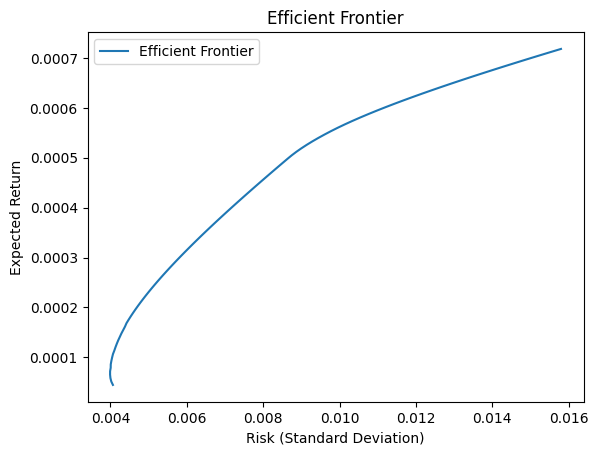

In [3]:
# Calculate mean returns and covariance matrix (if not already done)
mean_returns = mean_returns_table_long.values

# Number of assets
num_assets = len(mean_returns)

# Create a range of target returns
target_returns = np.linspace(min(mean_returns), max(mean_returns), num=100)

# Initialize an array to store minimum risks for each target return
efficient_frontier_risks = np.empty_like(target_returns, dtype=object)

# Calculate minimum risk for each target return
for i, target_return in enumerate(target_returns):
    # Define the weight variable for each asset
    weights = cp.Variable((num_assets, 1))

    # Define the expected return and risk (standard deviation) of the portfolio
    expected_return = mean_returns.T @ weights
    risk = cp.quad_form(weights, cov_matrix)

    # Define the optimization problem
    objective = cp.Minimize(risk)
    constraints = [expected_return == target_return, cp.sum(weights) == 1, weights >= 0]
    problem = cp.Problem(objective, constraints)

    # Solve the problem and check if successful
    problem.solve()
    if problem.status == cp.OPTIMAL:
        # Store the minimum risk for the target return
        efficient_frontier_risks[i] = np.sqrt(risk.value)
    else:
        # If optimization fails, store NaN
        efficient_frontier_risks[i] = np.nan

# Plot the Efficient Frontier
plt.plot(efficient_frontier_risks, target_returns, label='Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()


Portfolio Statistics for Risk Tolerance of 20%:
Optimal Weights:
[[3.25489476e-02]
 [1.70092398e-05]
 [6.19403336e-06]
 [6.96532504e-01]
 [2.17420503e-01]
 [2.62554904e-03]
 [5.08427045e-02]
 [3.27732028e-06]
 [3.31137798e-06]]
Expected Return: [[6.75273235e-05]]
Risk (Standard Deviation): [[0.00399062]]


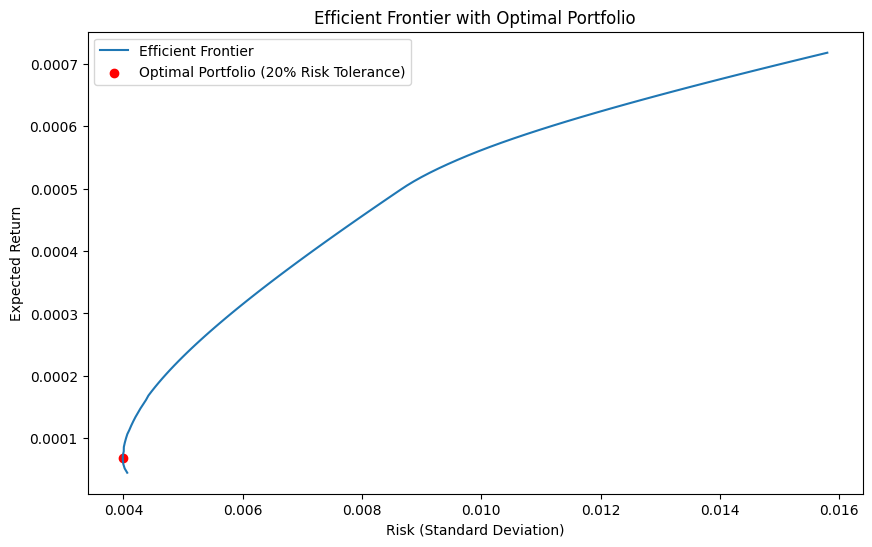

In [4]:
def allocate_portfolio(mean_returns, cov_matrix, risk_tolerance):
    # Number of assets
    num_assets = len(mean_returns)

    # Define the weight variable for each asset
    weights = cp.Variable((num_assets, 1))

    # Define the expected return and risk (standard deviation) of the portfolio
    expected_return = mean_returns.T @ weights
    risk = cp.quad_form(weights, cov_matrix)

    # Define the optimization problem
    objective = cp.Minimize(risk)
    constraints = [expected_return >= 0, cp.sum(weights) == 1, weights >= 0, risk <= risk_tolerance**2]
    problem = cp.Problem(objective, constraints)

    # Solve the problem and check if successful
    problem.solve()
    if problem.status == cp.OPTIMAL:
        optimal_weights = weights.value
        return optimal_weights
    else:
        return None

# Example: Allocate a portfolio with a risk tolerance of 20%
risk_tolerance = 0.20
optimal_weights = allocate_portfolio(mean_returns_table_long.values, cov_matrix.values, risk_tolerance)

# Calculate expected return and risk for the optimal weights
expected_return_optimal = np.dot(optimal_weights.T, mean_returns)
risk_optimal = np.sqrt(np.dot(np.dot(optimal_weights.T, cov_matrix), optimal_weights))

# Print the results
print("\nPortfolio Statistics for Risk Tolerance of 20%:")
print("Optimal Weights:")
print(optimal_weights)
print("Expected Return:", expected_return_optimal)
print("Risk (Standard Deviation):", risk_optimal)

# Visualize the portfolio on the Efficient Frontier plot
plt.figure(figsize=(10, 6))
plt.plot(efficient_frontier_risks, target_returns, label='Efficient Frontier')
plt.scatter([risk_optimal], [expected_return_optimal], color='red', marker='o', label='Optimal Portfolio (20% Risk Tolerance)')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Optimal Portfolio')
plt.legend()
plt.show()

Cumulative Returns: [[-0.09896258 -0.08814814 -0.07483909 ...  0.12346454 -0.04402804
  -0.06059996]
 [ 0.4636985   0.59347946  0.89319628 ... -0.03099469  0.23884811
   0.21635393]
 [ 0.44342934  0.41291162  0.39211131 ...  0.01865985  0.08584164
   0.10509222]
 ...
 [ 0.06487378  0.14867369  0.15916336 ...  0.16349119  0.37082088
   0.39897724]
 [-0.13389659 -0.03259295  0.04304054 ... -0.06191071 -0.26275176
  -0.26689969]
 [-0.10836451 -0.12851126 -0.13521524 ... -0.2872106  -0.05780951
  -0.07617482]]
Average Annual Return: 0.10503295859320251
Portfolio Volatility: 0.24355444727106113


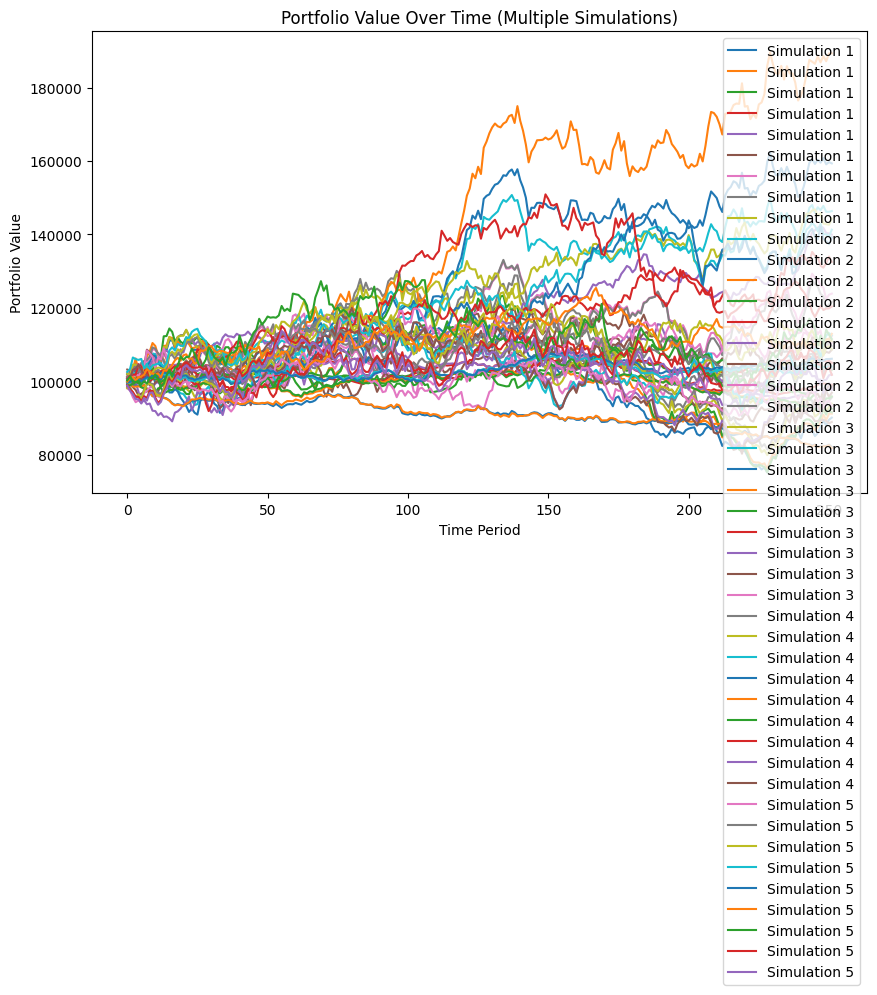

In [5]:
# Assuming optimal_weights, mean_returns_table_long, and cov_matrix are defined

# Set initial investment amount
initial_investment = 100000  # Choose an appropriate value

# Simulate portfolio returns over a specified period
num_simulations = 1000  # Adjust as needed
num_periods = 252  # Adjust as needed
portfolio_returns = np.random.multivariate_normal(mean_returns.flatten(), cov_matrix, size=(num_simulations, num_periods))

# Calculate portfolio values over time
portfolio_values = np.cumprod(1 + portfolio_returns, axis=1) * initial_investment

# Calculate performance metrics
cumulative_returns = portfolio_values[:, -1] / initial_investment - 1
average_annual_return = np.mean(np.prod(1 + portfolio_returns, axis=1) ** (252 / num_periods) - 1)
portfolio_volatility = np.std(cumulative_returns)

# Display performance metrics
print("Cumulative Returns:", cumulative_returns)
print("Average Annual Return:", average_annual_return)
print("Portfolio Volatility:", portfolio_volatility)

# Plot portfolio values over time for a few simulations
plt.figure(figsize=(10, 6))
for i in range(5):  # Plotting only 5 simulations for illustration
    plt.plot(portfolio_values[i], label=f"Simulation {i + 1}")

plt.xlabel("Time Period")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time (Multiple Simulations)")
plt.legend()
plt.show()

In [6]:
# Scenario Analysis

# Define different economic scenarios (e.g., bull market, bear market)
scenarios = {
    'Bull Market': 0.03,
    'Base Case': 0.00,
    'Bear Market': -0.02
}

# Assess portfolio performance under different scenarios
for scenario_name, expected_return_adjustment in scenarios.items():
    adjusted_expected_return = expected_return.value + expected_return_adjustment
    adjusted_risk = risk.value  # Adjust if needed based on scenario-specific considerations

    # Print or store results for each scenario
    print(f"\nResults for {scenario_name} Scenario:")
    print(f"Adjusted Expected Return: {adjusted_expected_return[0, 0]}")
    print(f"Adjusted Risk (Standard Deviation): {np.sqrt(adjusted_risk)[0, 0]}")



Results for Bull Market Scenario:
Adjusted Expected Return: 0.03071813683665028
Adjusted Risk (Standard Deviation): 0.015798328667214836

Results for Base Case Scenario:
Adjusted Expected Return: 0.0007181368366502821
Adjusted Risk (Standard Deviation): 0.015798328667214836

Results for Bear Market Scenario:
Adjusted Expected Return: -0.01928186316334972
Adjusted Risk (Standard Deviation): 0.015798328667214836


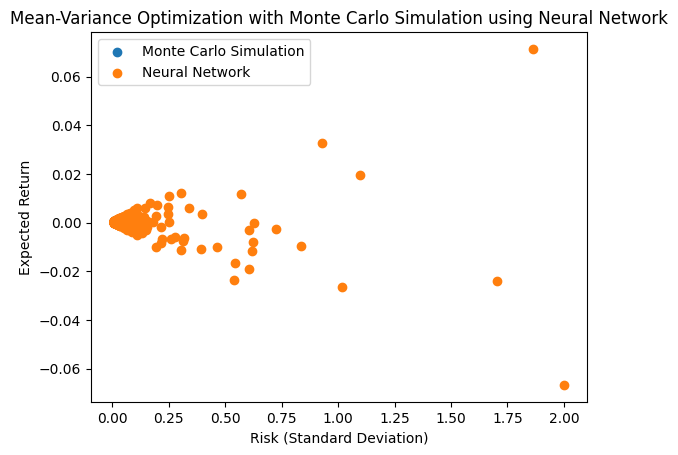

In [7]:
# Concatenate data for all asset classes
all_data = pd.concat([equity_data, fixed_income_data, commodities_data, reits_data], axis=1, keys=['Equity', 'Fixed Income', 'Commodities', 'REITs'])

# Drop NaN values
all_data = all_data.dropna()

# Calculate daily returns
returns = all_data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean(axis=0).values
cov_matrix = returns.cov().values

# Number of Monte Carlo simulations
num_simulations = 1000

# Initialize arrays to store results
portfolio_returns = np.zeros(num_simulations)
portfolio_risks = np.zeros(num_simulations)

# Number of assets
num_assets = len(mean_returns)

# Monte Carlo Simulation
for i in range(num_simulations):
    # Generate random weights for the portfolio
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    # Calculate portfolio returns and risks
    portfolio_returns[i] = np.sum(weights * mean_returns)
    portfolio_risks[i] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Reshape mean_returns to have the same number of features as returns
mean_returns = mean_returns.reshape(1, -1)

# Neural network for Mean-Variance Optimization
regressor = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500)
regressor.fit(returns, np.tile(mean_returns, (returns.shape[0], 1)))

# Generate random portfolio weights using the neural network
nn_weights = regressor.predict(np.random.normal(size=(num_simulations, returns.shape[1])))
nn_weights = nn_weights / np.sum(nn_weights, axis=1)[:, np.newaxis]

# Calculate returns and risks for portfolios generated by the neural network
nn_portfolio_returns = np.sum(nn_weights * mean_returns, axis=1)
nn_portfolio_risks = np.sqrt(np.diag(np.dot(np.dot(nn_weights, cov_matrix), nn_weights.T)))

# Plot the results
plt.scatter(portfolio_risks, portfolio_returns, label='Monte Carlo Simulation')
plt.scatter(nn_portfolio_risks, nn_portfolio_returns, label='Neural Network')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Mean-Variance Optimization with Monte Carlo Simulation using Neural Network')
plt.legend()
plt.show()


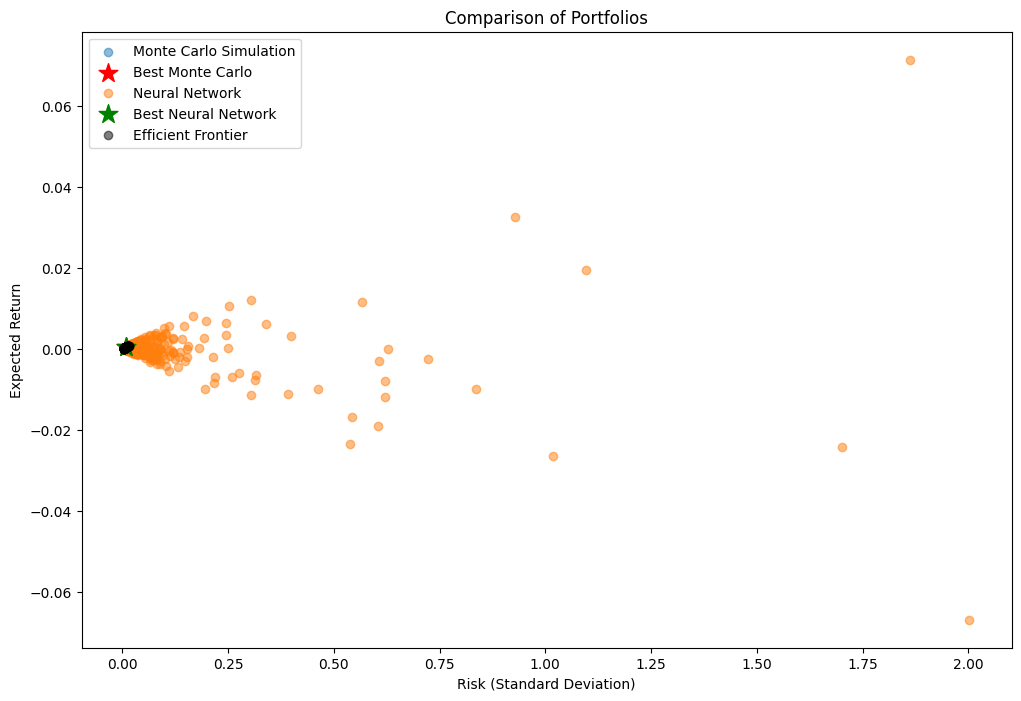

Monte Carlo Simulation - Best Portfolio:
Return: 0.00044305922987081036
Risk: 0.009016497564520741
Sharpe Ratio: 0.049138728946616264

Neural Network - Best Portfolio:
Return: 0.0005868293295996017
Risk: 0.009471381337917143
Sharpe Ratio: 0.061958156752735256


In [8]:
# Calculate Sharpe ratio for Monte Carlo Simulation
sharpe_ratio_monte_carlo = portfolio_returns / portfolio_risks

# Calculate Sharpe ratio for Neural Network
sharpe_ratio_nn = nn_portfolio_returns / nn_portfolio_risks

# Find the index of the portfolio with the highest Sharpe ratio for Monte Carlo Simulation
best_monte_carlo_index = np.argmax(sharpe_ratio_monte_carlo)
best_monte_carlo_return = portfolio_returns[best_monte_carlo_index]
best_monte_carlo_risk = portfolio_risks[best_monte_carlo_index]

# Find the index of the portfolio with the highest Sharpe ratio for Neural Network
best_nn_index = np.argmax(sharpe_ratio_nn)
best_nn_return = nn_portfolio_returns[best_nn_index]
best_nn_risk = nn_portfolio_risks[best_nn_index]

# Plot the results
plt.figure(figsize=(12, 8))

# Scatter plot for Monte Carlo Simulation
plt.scatter(portfolio_risks, portfolio_returns, label='Monte Carlo Simulation', alpha=0.5)
plt.scatter(portfolio_risks[best_monte_carlo_index], portfolio_returns[best_monte_carlo_index],
            marker='*', color='red', s=200, label='Best Monte Carlo')

# Scatter plot for Neural Network
plt.scatter(nn_portfolio_risks, nn_portfolio_returns, label='Neural Network', alpha=0.5)
plt.scatter(nn_portfolio_risks[best_nn_index], nn_portfolio_returns[best_nn_index],
            marker='*', color='green', s=200, label='Best Neural Network')

# Efficient Frontier from the original Mean-Variance Optimization
plt.scatter(efficient_frontier_risks, target_returns, label='Efficient Frontier', color='black', alpha=0.5)

plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Comparison of Portfolios')
plt.legend()
plt.show()

# Print metrics
print("Monte Carlo Simulation - Best Portfolio:")
print("Return:", best_monte_carlo_return)
print("Risk:", best_monte_carlo_risk)
print("Sharpe Ratio:", sharpe_ratio_monte_carlo[best_monte_carlo_index])

print("\nNeural Network - Best Portfolio:")
print("Return:", best_nn_return)
print("Risk:", best_nn_risk)
print("Sharpe Ratio:", sharpe_ratio_nn[best_nn_index])


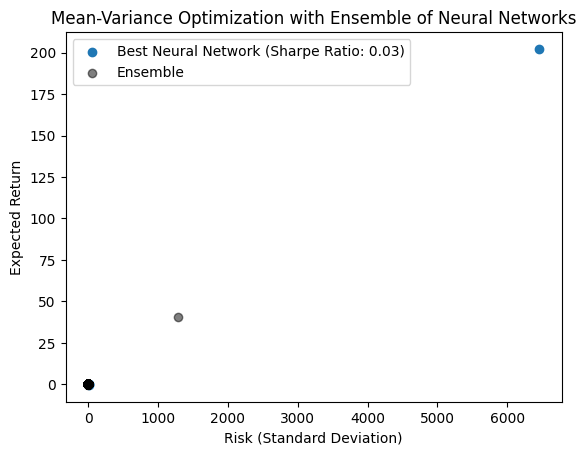

In [9]:
num_simulations = 1000
num_networks = 5  # Number of neural networks in the ensemble

# Initialize arrays to store results
portfolio_returns = np.zeros((num_simulations, num_networks))
portfolio_risks = np.zeros((num_simulations, num_networks))
sharpe_ratios = np.zeros(num_networks)

# Monte Carlo Simulation
for i in range(num_networks):
    # Define different parameters for each neural network
    hidden_units = np.random.choice([32, 64, 128])  # Randomly choose the number of hidden units

    # Neural network for Mean-Variance Optimization
    regressor = MLPRegressor(hidden_layer_sizes=(hidden_units,), max_iter=500, random_state=i)
    regressor.fit(returns, np.tile(mean_returns, (returns.shape[0], 1)))

    # Generate random portfolio weights using the neural network
    nn_weights = regressor.predict(np.random.normal(size=(num_simulations, returns.shape[1])))
    nn_weights = nn_weights / np.sum(nn_weights, axis=1)[:, np.newaxis]

    # Calculate returns and risks for portfolios generated by the neural network
    portfolio_returns[:, i] = np.sum(nn_weights * mean_returns, axis=1)
    portfolio_risks[:, i] = np.sqrt(np.diag(np.dot(np.dot(nn_weights, cov_matrix), nn_weights.T)))

    # Calculate Sharpe Ratio
    sharpe_ratios[i] = np.mean(portfolio_returns[:, i]) / np.mean(portfolio_risks[:, i])

# Find the neural network configuration with the highest Sharpe Ratio
best_network_index = np.argmax(sharpe_ratios)

# Plot the results for the best neural network
plt.scatter(portfolio_risks[:, best_network_index], portfolio_returns[:, best_network_index], label=f'Best Neural Network (Sharpe Ratio: {sharpe_ratios[best_network_index]:.2f})')

# Calculate the ensemble results (e.g., take the mean)
ensemble_portfolio_returns = np.mean(portfolio_returns, axis=1)
ensemble_portfolio_risks = np.mean(portfolio_risks, axis=1)

# Plot the ensemble results
plt.scatter(ensemble_portfolio_risks, ensemble_portfolio_returns, label='Ensemble', color='black', alpha=0.5)

plt.legend()
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Mean-Variance Optimization with Ensemble of Neural Networks')
plt.show()


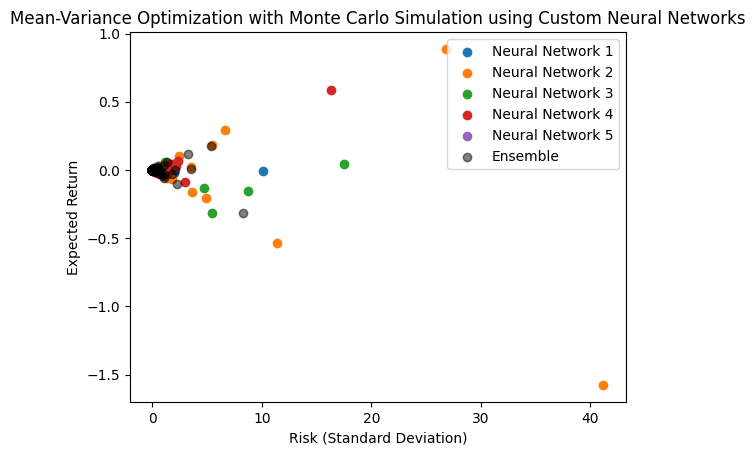

Neural Network 1:
Return: 0.00028534845121853936
Risk: 0.0529782421959561
Sharpe Ratio: 0.02127027543674704


Neural Network 2:
Return: -0.0010517172939253114
Risk: 0.15936069471405603
Sharpe Ratio: 0.012862277388437142


Neural Network 3:
Return: -1.6470734617441307e-05
Risk: 0.06967108774200553
Sharpe Ratio: 0.022432225633299198


Neural Network 4:
Return: 0.0009336427825651351
Risk: 0.0927853760623901
Sharpe Ratio: 0.014528697289822331


Neural Network 5:
Return: 0.0004552627295198003
Risk: 0.014927869628696822
Sharpe Ratio: 0.03662560432665982




In [10]:
# Number of Monte Carlo simulations
num_simulations = 1000

# Define different neural network structures
network_structures = [
    {'hidden_layer_sizes': (50,), 'max_iter': 1000, 'activation': 'relu'},
   # {'hidden_layer_sizes': (100,50), 'max_iter': 1000, 'activation': 'relu'},
    {'hidden_layer_sizes': (100,50,25), 'max_iter': 1000, 'activation': 'relu'},
   # {'hidden_layer_sizes': (50,), 'max_iter': 1000, 'activation': 'tanh'},

    {'hidden_layer_sizes': (100, 50), 'max_iter': 1500, 'activation': 'relu'},
    {'hidden_layer_sizes': (200, 100, 50), 'max_iter': 2000, 'activation': 'tanh'},
    {'hidden_layer_sizes': (150, 75, 25), 'max_iter': 1500, 'activation': 'logistic'},

]

# Initialize arrays to store results
all_networks_returns = np.zeros((num_simulations, len(network_structures)))
all_networks_risks = np.zeros((num_simulations, len(network_structures)))

# Run Monte Carlo simulations for different neural networks
for i, structure in enumerate(network_structures):
    # Neural network for Mean-Variance Optimization
    regressor = MLPRegressor(**structure)
    regressor.fit(returns, np.tile(mean_returns, (returns.shape[0], 1)))

    # Generate random portfolio weights using the neural network
    nn_weights = regressor.predict(np.random.normal(size=(num_simulations, returns.shape[1])))
    nn_weights = nn_weights / np.sum(nn_weights, axis=1)[:, np.newaxis]

    # Calculate returns and risks for portfolios generated by the neural network
    all_networks_returns[:, i] = np.sum(nn_weights * mean_returns, axis=1)
    all_networks_risks[:, i] = np.sqrt(np.diag(np.dot(np.dot(nn_weights, cov_matrix), nn_weights.T)))

# Plot the results for each neural network
for i in range(len(network_structures)):
    plt.scatter(all_networks_risks[:, i], all_networks_returns[:, i], label=f'Neural Network {i + 1}')

# Calculate the ensemble results (e.g., take the mean)
ensemble_portfolio_returns = np.mean(all_networks_returns, axis=1)
ensemble_portfolio_risks = np.mean(all_networks_risks, axis=1)

# Plot the ensemble results
plt.scatter(ensemble_portfolio_risks, ensemble_portfolio_returns, label='Ensemble', color='black', alpha=0.5)

plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Mean-Variance Optimization with Monte Carlo Simulation using Custom Neural Networks')
plt.legend()
plt.show()

# Calculate the Sharpe ratio for each neural network
all_networks_sharpe_ratios = all_networks_returns / all_networks_risks

# Print the Sharpe ratio for each neural network
for i, structure in enumerate(network_structures):
    print(f'Neural Network {i + 1}:')
    print(f'Return: {np.mean(all_networks_returns[:, i])}')
    print(f'Risk: {np.mean(all_networks_risks[:, i])}')
    print(f'Sharpe Ratio: {np.mean(all_networks_sharpe_ratios[:, i])}')
    print('\n')


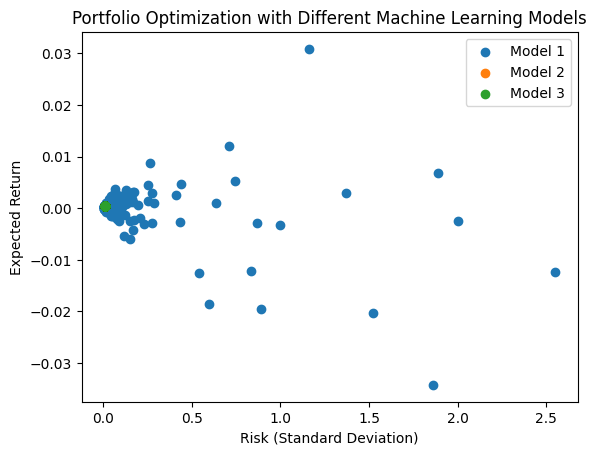

Neural Network 1 - Sharpe Ratio: 0.005386144186571754
Neural Network 2 - Sharpe Ratio: -0.006599602843175527
Neural Network 3 - Sharpe Ratio: -0.0002364070255144144
Neural Network 4 - Sharpe Ratio: 0.010062391533956187
Neural Network 5 - Sharpe Ratio: 0.030497501709461538

Ensemble - Sharpe Ratio: 0.0015551186723521898


In [11]:
# Number of Monte Carlo simulations
num_simulations = 1000

# Define different machine learning models and hyperparameters
models = [
    {'model': MLPRegressor(), 'params': {'hidden_layer_sizes': [(50,), (100, 50)], 'max_iter': [500, 1000], 'activation': ['tanh']}},
    {'model': RandomForestRegressor(), 'params': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}},
    {'model': LinearRegression(), 'params': {}}
]

# Initialize arrays to store results
all_models_returns = np.zeros((num_simulations, len(models)))
all_models_risks = np.zeros((num_simulations, len(models)))

# Run Monte Carlo simulations for different machine learning models
for i, model_info in enumerate(models):
    model = model_info['model']
    param_grid = model_info['params']

    # Use ParameterGrid to get all combinations of hyperparameters
    param_combinations = ParameterGrid(param_grid)

    best_sharpe_ratio = -np.inf
    best_weights = None

    # Iterate over all hyperparameter combinations
    for params in param_combinations:
        # Set hyperparameters for the model
        model.set_params(**params)

        # Train the model on historical data
        model.fit(returns, np.tile(mean_returns, (returns.shape[0], 1)))

        # Generate random portfolio weights using the model
        weights = model.predict(np.random.normal(size=(num_simulations, returns.shape[1])))
        weights = weights / np.sum(weights, axis=1)[:, np.newaxis]

        # Calculate returns and risks for portfolios generated by the model
        returns_portfolio = np.sum(weights * mean_returns, axis=1)
        risks_portfolio = np.sqrt(np.diag(np.dot(np.dot(weights, cov_matrix), weights.T)))

        # Calculate Sharpe ratio for the portfolio
        sharpe_ratio = np.mean(returns_portfolio) / np.mean(risks_portfolio)

        # Check if this combination of hyperparameters gives a better Sharpe ratio
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            best_weights = weights

    # Store the results for the best combination of hyperparameters
    all_models_returns[:, i] = np.sum(best_weights * mean_returns, axis=1)
    all_models_risks[:, i] = np.sqrt(np.diag(np.dot(np.dot(best_weights, cov_matrix), best_weights.T)))

# Plot the results for each machine learning model
for i in range(len(models)):
    plt.scatter(all_models_risks[:, i], all_models_returns[:, i], label=f'Model {i + 1}')

plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Portfolio Optimization with Different Machine Learning Models')
plt.legend()
plt.show()

# Calculate Sharpe ratio for each neural network
sharpe_ratios = []

for i in range(len(network_structures)):
    returns_nn = all_networks_returns[:, i]
    risks_nn = all_networks_risks[:, i]

    # Calculate Sharpe ratio
    sharpe_ratio_nn = np.mean(returns_nn) / np.mean(risks_nn)
    sharpe_ratios.append(sharpe_ratio_nn)

    # Print Sharpe ratio for each neural network
    print(f"Neural Network {i + 1} - Sharpe Ratio: {sharpe_ratio_nn}")

# Calculate Sharpe ratio for the ensemble
returns_ensemble = ensemble_portfolio_returns
risks_ensemble = ensemble_portfolio_risks

sharpe_ratio_ensemble = np.mean(returns_ensemble) / np.mean(risks_ensemble)

# Print Sharpe ratio for the ensemble
print(f"\nEnsemble - Sharpe Ratio: {sharpe_ratio_ensemble}")


In [12]:
# Function to calculate negative Sharpe ratio (for minimization)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_risk

# Optimize portfolio weights for the ensemble
result = minimize(negative_sharpe_ratio, np.ones(len(network_structures)) / len(network_structures),
                  args=(np.mean(all_networks_returns, axis=0), np.cov(all_networks_returns.T)),
                  method='SLSQP', bounds=[(0, 1)] * len(network_structures), constraints={'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Get optimized weights
optimized_weights = result.x

# Calculate returns and risks for the optimized ensemble portfolio
optimized_returns = np.sum(all_networks_returns * optimized_weights, axis=1)
cov_matrix = np.cov(all_networks_returns.T)
optimized_risks = np.sqrt(np.dot(np.dot(optimized_weights, cov_matrix), optimized_weights.T))

# Calculate Sharpe ratio for the optimized ensemble
optimized_sharpe_ratio = np.mean(optimized_returns) / np.mean(optimized_risks)

# Print the optimized Sharpe ratio
print(f"\nOptimized Ensemble - Sharpe Ratio: {optimized_sharpe_ratio}")



Optimized Ensemble - Sharpe Ratio: 0.5498314122963044


In [13]:
# Find the indices of the neural networks with the highest weights
top_network_indices = np.argsort(optimized_weights)[-3:][::-1]  # Adjust the number as needed

# Print the weights and indices of the top neural networks
for i, index in enumerate(top_network_indices):
    print(f"Neural Network {index + 1} - Weight: {optimized_weights[index]}")


Neural Network 5 - Weight: 0.8634113653172266
Neural Network 1 - Weight: 0.13347294206290683
Neural Network 4 - Weight: 0.002878388253610231


In [14]:
# Function to calculate negative Sharpe ratio (for minimization)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, all_networks_returns):
    portfolio_return = np.dot(weights, np.mean(all_networks_returns, axis=0))
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_risk

# Optimize portfolio weights for the ensemble
result = minimize(negative_sharpe_ratio, np.ones(len(network_structures)) / len(network_structures),
                  args=(np.mean(all_networks_returns, axis=0), np.cov(all_networks_returns.T), all_networks_returns),
                  method='SLSQP', bounds=[(0, 1)] * len(network_structures), constraints={'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Get optimized weights
optimized_weights = result.x

# Print the weights for each neural network in the ensemble
for i, weight in enumerate(optimized_weights):
    print(f"Neural Network {i + 1} - Weight: {weight}")

# Calculate returns and risks for the optimized ensemble portfolio
optimized_returns = np.sum(all_networks_returns * optimized_weights, axis=1)
cov_matrix = np.cov(all_networks_returns.T)
optimized_risks = np.sqrt(np.dot(np.dot(optimized_weights, cov_matrix), optimized_weights.T))

# Calculate Sharpe ratio for the optimized ensemble
optimized_sharpe_ratio = np.mean(optimized_returns) / np.mean(optimized_risks)

# Print the optimized Sharpe ratio
print(f"\nOptimized Ensemble - Sharpe Ratio: {optimized_sharpe_ratio}")

Neural Network 1 - Weight: 0.13347294206290683
Neural Network 2 - Weight: 2.2013273138430494e-17
Neural Network 3 - Weight: 0.0002373043662562299
Neural Network 4 - Weight: 0.002878388253610231
Neural Network 5 - Weight: 0.8634113653172266

Optimized Ensemble - Sharpe Ratio: 0.5498314122963044


In [15]:
from scipy.optimize import minimize

# Function to calculate negative Sharpe ratio (for minimization)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_risk

# Assuming mean_returns_table is a DataFrame with mean returns and cov_matrix is a DataFrame with covariance matrix

mean_returns = mean_returns_table.stack().reset_index(level=1, drop=True).to_frame(name='Mean Returns')
print(mean_returns)
cov_matrix = pd.concat([equity_returns, fixed_income_returns, commodities_returns, reits_returns], axis=1).cov()

# Convert mean_returns_table and cov_matrix to numpy arrays

cov_matrix = cov_matrix.values

# Initial weights (equal weight allocation)
initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

# Constraints for optimization (weights sum to 1)
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Bounds for optimization (weights between 0 and 1)
bounds = [(0, 1) for _ in range(len(mean_returns))]

# Optimize portfolio weights
result = minimize(negative_sharpe_ratio, initial_weights,
                  args=(mean_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimized weights
optimized_weights = result.x

# Print the optimized weights
print("Optimized Weights:", optimized_weights)

# Calculate returns and risks for the optimized portfolio
optimized_portfolio_return = np.dot(optimized_weights, mean_returns)
optimized_portfolio_risk = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))

# Calculate Sharpe ratio for the optimized portfolio
optimized_sharpe_ratio = optimized_portfolio_return / optimized_portfolio_risk

# Print the results
print("\nOptimized Portfolio Metrics:")
print("Return:", optimized_portfolio_return)
print("Risk:", optimized_portfolio_risk)
print("Sharpe Ratio:", optimized_sharpe_ratio)

print("Number of weights:", len(optimized_weights))
print("Number of asset classes:", len(mean_returns))


         Mean Returns
Ticker               
^DJI         0.000418
^GSPC        0.000557
^IXIC        0.000718
AGG          0.000038
BND          0.000041
GLD          0.000381
^SPGSCI      0.000350
IYR          0.000299
VNQ          0.000313
Optimized Weights: [1.46558908e-17 1.24844134e-17 3.81566423e-01 0.00000000e+00
 1.08710841e-17 5.60503458e-01 5.79301187e-02 0.00000000e+00
 0.00000000e+00]

Optimized Portfolio Metrics:
Return: [0.00050799]
Risk: 0.008800713681471246
Sharpe Ratio: [0.05772181]
Number of weights: 9
Number of asset classes: 9



Combined Returns:
Ticker          ^DJI     ^GSPC     ^IXIC       AGG       BND       GLD  \
Date                                                                     
2019-01-28 -0.008448 -0.007847 -0.011051 -0.000562  0.000378  0.003500   
2019-01-29  0.002109 -0.001456 -0.008099  0.002626  0.002013  0.005597   
2019-01-30  0.017693  0.015549  0.022024  0.002245  0.001005  0.005727   
2019-01-31 -0.000607  0.008597  0.013735  0.002987  0.004641  0.000481   
2019-02-01  0.002569  0.000899 -0.002454 -0.002071 -0.002779 -0.002004   

Ticker       ^SPGSCI       IYR       VNQ  
Date                                      
2019-01-28 -0.020528  0.009053  0.009818  
2019-01-29  0.014504  0.007988  0.007877  
2019-01-30  0.008057  0.007925  0.008060  
2019-01-31 -0.006068  0.010524  0.010418  
2019-02-01  0.013263 -0.006823 -0.006354  


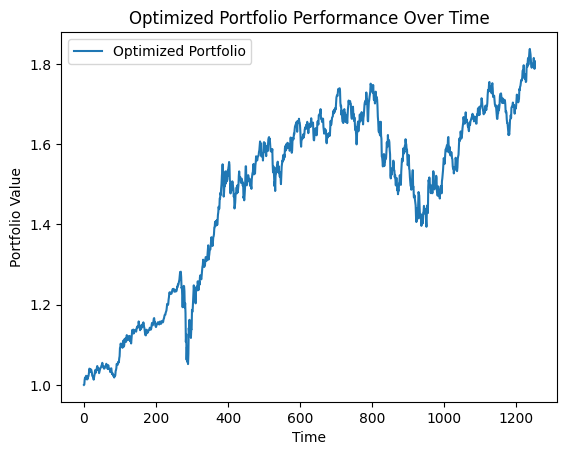

In [16]:
# Assuming equity_returns, fixed_income_returns, commodities_returns, reits_returns are already defined

# Concatenate returns for all asset classes
all_returns = pd.concat([equity_returns, fixed_income_returns, commodities_returns, reits_returns], axis=1)

# Display the first few rows of the combined returns
print("\nCombined Returns:")
print(all_returns.head())

# Check if the number of weights matches the number of asset classes
if len(optimized_weights) != len(all_returns.columns):
    raise ValueError("Number of weights must match the number of asset classes")

# Calculate the portfolio value over time
portfolio_values = [1.0]  # Initial portfolio value
for i in range(1, len(all_returns)):
    # Calculate the portfolio value at each time step
    portfolio_value = portfolio_values[-1] * (1 + np.dot(optimized_weights, all_returns.iloc[i]))
    portfolio_values.append(portfolio_value)

# Plot the portfolio value over time
plt.plot(portfolio_values, label='Optimized Portfolio')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Optimized Portfolio Performance Over Time')
plt.legend()
plt.show()

Performance Metrics:
Cumulative Return: 0.8062437209589046
Annualized Return: 0.12626910499745359
Annualized Standard Deviation: 0.13965123843697191
Sharpe Ratio: 0.9041746167861017


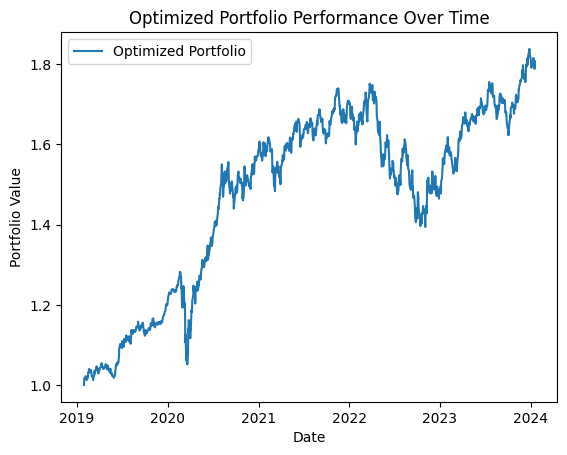

In [22]:
# Assuming equity_returns, fixed_income_returns, commodities_returns, reits_returns are already defined

# Concatenate returns for all asset classes
all_returns = pd.concat([equity_returns, fixed_income_returns, commodities_returns, reits_returns], axis=1)

# Assuming optimized_weights is already defined
# Check if the number of weights matches the number of asset classes
if len(optimized_weights) != len(all_returns.columns):
    raise ValueError("Number of weights must match the number of asset classes")

# Calculate the portfolio value over time
portfolio_values = [1.0]  # Initial portfolio value
for i in range(1, len(all_returns)):
    # Calculate the portfolio value at each time step
    portfolio_value = portfolio_values[-1] * (1 + np.dot(optimized_weights, all_returns.iloc[i]))
    portfolio_values.append(portfolio_value)

# Calculate additional metrics
cumulative_return = (portfolio_values[-1] / portfolio_values[0]) - 1
daily_returns = all_returns.dot(optimized_weights)
annualized_return = (1 + cumulative_return) ** (1 / (len(all_returns) / 252)) - 1  # Assuming 252 trading days in a year
standard_deviation = np.std(daily_returns) * np.sqrt(252)  # Annualized standard deviation
sharpe_ratio = annualized_return / standard_deviation

# Print the results
print("Performance Metrics:")
print("Cumulative Return:", cumulative_return)
print("Annualized Return:", annualized_return)
print("Annualized Standard Deviation:", standard_deviation)
print("Sharpe Ratio:", sharpe_ratio)

# Plot the portfolio value over time
plt.plot(all_returns.index[1:], portfolio_values[1:], label='Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Optimized Portfolio Performance Over Time')
plt.legend()
plt.show()

# Interpretation and Analysis
- The cumulative return of 0.8062 indicates an overall gain of 80.62% during the analyzed period.
- The annualized return of 0.1263 suggests an average annual gain of 12.63%, adjusted for the total number of trading days.
- The annualized standard deviation measures the portfolio's risk, and a lower value is generally favorable.
- The Sharpe ratio of 0.90 indicates a solid risk-adjusted performance, with higher values being desirable.
- The graph visually represents the growth of the portfolio over time.


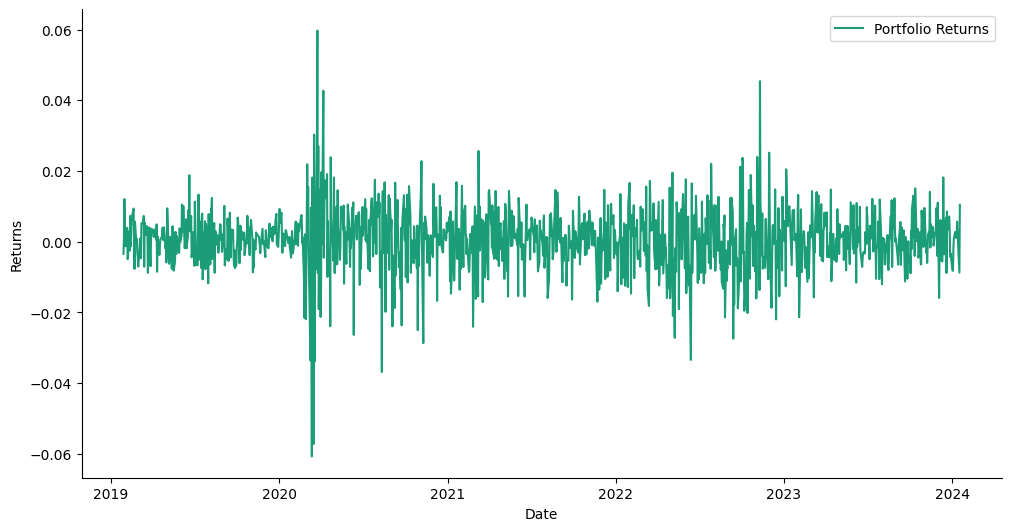

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series.index
    ys = series.values

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Daily_returns is the DataFrame to plot
fig, ax = plt.subplots(figsize=(10, 5.2), constrained_layout=True)
df_sorted = daily_returns.sort_index()  # Sorting by date if needed
_plot_series(df_sorted, 'Portfolio Returns')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()
